<a href="https://colab.research.google.com/github/AnjanDutta/EEEM068/blob/main/Notebooks/Few_shot_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<H1 style="text-align: center">EEEM068 - Applied Machine Learning</H1>
<H1 style="text-align: center">Workshop 06</H1>
<H1 style="text-align: center">Few-shot Learning Tutorial</H1>

In this tutorial, we will work on algorithms that learn models which can quickly adapt to new classes and/or tasks with few samples. This area of machine learning is called _Meta-Learning_ that has a lot of application on Few-shot Learning.

Meta-Learning offers solutions to these situations, and we will discuss one of the popular meta-learning algorithms: __Prototypical Networks (ProtoNet)__ ([Snell et al., 2017](https://arxiv.org/pdf/1703.05175.pdf)) which is applied for few-shot image classification task. We will focus on the task of few-shot classification where the training and test set have distinct sets of classes. For instance, we would train the model on the binary classifications of cats-birds and flowers-bikes, but during test time, the model would need to learn from 4 examples each the difference between dogs and otters, two classes we have not seen during training (Figure credit - [Lilian Weng](https://lilianweng.github.io/lil-log/2018/11/30/meta-learning.html)).

<center width="100%"><img src="https://lilianweng.github.io/posts/2018-11-30-meta-learning/few-shot-classification.png" width="800px"></center>

For few-shot classification, we consider a task to distinguish between $M$ novel classes. Here, we would not only have novel classes, but also a completely different dataset.



## Few-shot classification

We start our implementation by discussing the dataset setup. In this notebook, we will use CIFAR-100; a description of CIFAR-100 can be found at [this link](https://www.cs.toronto.edu/~kriz/cifar.html).

### CIFAR-100

CIFAR-100 has 100 classes each with 600 images of size $32\times 32$ pixels. Instead of splitting the training, validation, and test set over examples, we will split them over classes: we will use 80 classes for training, and 10 for validation, and 10 for testing. Our overall goal is to obtain a model that can distinguish between the 10 test classes with seeing very few examples. First, let's load the dataset and visualize some examples.

In [1]:
# Loading CIFAR100 dataset
import torchvision
from torchvision import transforms
from torchvision.datasets import CIFAR100
CIFAR_train_set = CIFAR100(root='./data/', train=True, download=True, transform=transforms.ToTensor())
CIFAR_test_set = CIFAR100(root='./data/', train=False, download=True, transform=transforms.ToTensor())

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 169M/169M [00:06<00:00, 24.5MB/s]


### Visualization

/tmp/ipykernel_4151/1095125301.py:9: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


<Figure size 640x480 with 0 Axes>

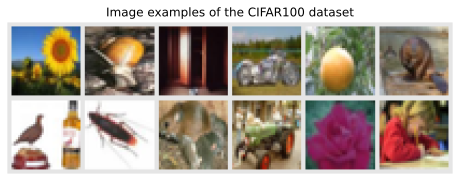

In [7]:
# Visualize some examples
import torch
import numpy as np
## Imports for plotting
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()

NUM_IMAGES = 12
CIFAR_images = torch.stack([CIFAR_train_set[np.random.randint(len(CIFAR_train_set))][0] for idx in range(NUM_IMAGES)], dim=0)
img_grid = torchvision.utils.make_grid(CIFAR_images, nrow=6, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8,8))
plt.title("Image examples of the CIFAR100 dataset")
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

### Data preprocessing

Next, we need to prepare the dataset in the training, validation and test split as mentioned before. The torchvision package gives us the training and test set as two separate dataset objects. The next code cells will merge the original training and test set, and then create the new train-val-test split.

In [14]:
# Merging original training and test set
CIFAR_all_images = np.concatenate([CIFAR_train_set.data, CIFAR_test_set.data], axis=0)
CIFAR_all_targets = torch.LongTensor(CIFAR_train_set.targets + CIFAR_test_set.targets)

To have an easier time handling the dataset, we define our own, simple dataset class below. It takes a set of images, labels/targets, and image transformations, and returns the corresponding images and labels element-wise.

In [23]:
from PIL import Image
import torch.utils.data as data
class ImageDataset(data.Dataset):
    def __init__(self, imgs, targets, img_transform=None):
        """
        Inputs:
            imgs - Numpy array of shape [N,32,32,3] containing all images.
            targets - PyTorch array of shape [N] containing all labels.
            img_transform - A torchvision transformation that should be applied
                            to the images before returning. If none, no transformation
                            is applied.
        """
        super().__init__()
        self.img_transform = img_transform
        self.imgs = imgs
        self.targets = targets

    def __getitem__(self, idx):
        img, target = self.imgs[idx], self.targets[idx]
        img = Image.fromarray(img)

        if self.img_transform is not None:
            img = self.img_transform(img)

        return img, target

    def __len__(self):
        return self.imgs.shape[0]

Now, we can create the class splits. We will assign the classes randomly to training, validation and test, and use a 80%-10%-10% split.

In [24]:
torch.manual_seed(0)           # Set seed for reproducibility
classes = torch.randperm(100)  # Returns random permutation of numbers 0 to 99
train_classes, val_classes, test_classes = classes[:80], classes[80:90], classes[90:]

To get an intuition of the validation and test classes, we print the class names below:

In [25]:
# Printing validation and test classes
idx_to_class = {val: key for key, val in CIFAR_train_set.class_to_idx.items()}
print("Validation classes:", [idx_to_class[c.item()] for c in val_classes])
print("Test classes:", [idx_to_class[c.item()] for c in test_classes])

Validation classes: ['caterpillar', 'castle', 'skunk', 'ray', 'bus', 'motorcycle', 'keyboard', 'chimpanzee', 'possum', 'tiger']
Test classes: ['kangaroo', 'crocodile', 'butterfly', 'shark', 'forest', 'pickup_truck', 'telephone', 'lion', 'worm', 'mushroom']


As we can see, the classes have quite some variety and some classes might be easier to distinguish than others. For instance, in the test classes, 'pickup_truck' is the only vehicle while the classes 'mushroom', 'worm' and 'forest' might be harder to keep apart. Remember that we want to learn the classification of those ten classes from 80 other classes in our training set, and few examples from the actual test classes. We will experiment with the number of examples per class. Finally, we can create the training, validation and test dataset according to our split above. For this, we create dataset objects of our previously defined class `ImageDataset`.

In [26]:
def dataset_from_labels(imgs, targets, class_set, **kwargs):
    class_mask = (targets[:,None] == class_set[None,:]).any(dim=-1)
    return ImageDataset(imgs=imgs[class_mask],
                        targets=targets[class_mask],
                        **kwargs)

As in our experiments before on CIFAR in Tutorial 5, 6 and 9, we normalize the dataset. Additionally, we use small augmentations during training to prevent overfitting.

In [27]:
# Pre-computed statistics from the new train set
DATA_MEANS = torch.Tensor([0.5183975 , 0.49192241, 0.44651328])
DATA_STD = torch.Tensor([0.26770132, 0.25828985, 0.27961241])

test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize(
                                         DATA_MEANS, DATA_STD)
                                     ])
# For training, we add some augmentation.
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                      transforms.RandomResizedCrop(
                                          (32, 32), scale=(0.8, 1.0), ratio=(0.9, 1.1)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(
                                          DATA_MEANS, DATA_STD)
                                      ])

train_set = dataset_from_labels(
    CIFAR_all_images, CIFAR_all_targets, train_classes, img_transform=train_transform)
val_set = dataset_from_labels(
    CIFAR_all_images, CIFAR_all_targets, val_classes, img_transform=test_transform)
test_set = dataset_from_labels(
    CIFAR_all_images, CIFAR_all_targets, test_classes, img_transform=test_transform)

### Data sampling

The strategy of how to use the available training data for learning few-shot adaptation is crucial in meta-learning. The meta-learning algorithms that we use here is based on the idea: simulate few-shot learning during training. Specifically, at each training step, we randomly select a small number of classes and sample a small number of examples for each class. This represents our few-shot training batch, which we also refer to as **support set**. Additionally, we sample a second set of examples from the same classes and refer to this batch as **query set**. Our training objective is to classify the query set correctly from seeing the support set and its corresponding labels.

The following subsection summarizes the code that is needed to create such training batches. In PyTorch, we can specify the data sampling procedure by so-called `Sampler` ([documentation](https://pytorch.org/docs/stable/data.html#data-loading-order-and-sampler)). Samplers are iterable objects that return indices in the order in which the data elements should be sampled. In our previous notebooks, we usually used the option `shuffle=True` in the `data.DataLoader` objects which creates a sampler returning the data indices in random order. Here, we focus on samplers that return batches of indices that correspond to support and query set batches. Below, we implement such a sampler.

In [28]:
import random
from collections import defaultdict

class FewShotBatchSampler(object):

    def __init__(self, dataset_targets, N_way, K_shot, include_query=False, shuffle=True, shuffle_once=False):
        """
        Inputs:
            dataset_targets - PyTorch tensor of the labels of the data elements.
            N_way - Number of classes to sample per batch.
            K_shot - Number of examples to sample per class in the batch.
            include_query - If True, returns batch of size N_way*K_shot*2, which
                            can be split into support and query set. Simplifies
                            the implementation of sampling the same classes but
                            distinct examples for support and query set.
            shuffle - If True, examples and classes are newly shuffled in each
                      iteration (for training)
            shuffle_once - If True, examples and classes are shuffled once in
                           the beginning, but kept constant across iterations
                           (for validation)
        """
        super().__init__()
        self.dataset_targets = dataset_targets
        self.N_way = N_way
        self.K_shot = K_shot
        self.shuffle = shuffle
        self.include_query = include_query
        if self.include_query:
            self.K_shot *= 2
        self.batch_size = self.N_way * self.K_shot  # Number of overall images per batch

        # Organize examples by class
        self.classes = torch.unique(self.dataset_targets).tolist()
        self.num_classes = len(self.classes)
        self.indices_per_class = {}
        self.batches_per_class = {}  # Number of K-shot batches that each class can provide
        for c in self.classes:
            self.indices_per_class[c] = torch.where(self.dataset_targets == c)[0]
            self.batches_per_class[c] = self.indices_per_class[c].shape[0] // self.K_shot

        # Create a list of classes from which we select the N classes per batch
        self.iterations = sum(self.batches_per_class.values()) // self.N_way
        self.class_list = [c for c in self.classes for _ in range(self.batches_per_class[c])]
        if shuffle_once or self.shuffle:
            self.shuffle_data()
        else:
            # For testing, we iterate over classes instead of shuffling them
            sort_idxs = [i+p*self.num_classes for i,
                         c in enumerate(self.classes) for p in range(self.batches_per_class[c])]
            self.class_list = np.array(self.class_list)[np.argsort(sort_idxs)].tolist()

    def shuffle_data(self):
        # Shuffle the examples per class
        for c in self.classes:
            perm = torch.randperm(self.indices_per_class[c].shape[0])
            self.indices_per_class[c] = self.indices_per_class[c][perm]
        # Shuffle the class list from which we sample. Note that this way of shuffling
        # does not prevent to choose the same class twice in a batch. However, for
        # training and validation, this is not a problem.
        random.shuffle(self.class_list)

    def __iter__(self):
        # Shuffle data
        if self.shuffle:
            self.shuffle_data()

        # Sample few-shot batches
        start_index = defaultdict(int)
        for it in range(self.iterations):
            class_batch = self.class_list[it*self.N_way:(it+1)*self.N_way]  # Select N classes for the batch
            index_batch = []
            for c in class_batch:  # For each class, select the next K examples and add them to the batch
                index_batch.extend(self.indices_per_class[c][start_index[c]:start_index[c]+self.K_shot])
                start_index[c] += self.K_shot
            if self.include_query:  # If we return support+query set, sort them so that they are easy to split
                index_batch = index_batch[::2] + index_batch[1::2]
            yield index_batch

    def __len__(self):
        return self.iterations

Note that this sampler eventually allows the sampling of batches where we use a class twice due to a simpler shuffling function (`shuffle_data`). In other words, during training or validation, if we sample batches for a 5-class 4-shot training setting, it can occasionally happen that we get a batch where 2 of the 5 classes are identical. Since we have 80 classes to choose from, this however happens relatively rarely. Further, it actually does not constitute any issue if the code for the meta-learning methods support variable number of classes and shots per class. Nonetheless, when the number of classes/tasks is smaller, it is recommended to replace the `shuffle_data` method with a sampler that prevents picking the same class twice in a batch.

Now, we can create our intended data loaders by passing an object of `FewShotBatchSampler` as `batch_sampler=...` input to the PyTorch data loader object. For our experiments, we will use a 5-class 4-shot training setting. This means that each support set contains 5 classes with 4 examples each, i.e., 20 images overall. Usually, it is good to keep the number of shots equal to the number that you aim to test on. However, we will experiment later with a different number of shots, and hence, we pick 4 as a compromise for now. To get the best-performing model, it is recommended to consider the number of training shots as hyperparameters in a grid search.

In [29]:
N_WAY = 5
K_SHOT = 4
train_loader = data.DataLoader(train_set, batch_sampler=FewShotBatchSampler(train_set.targets,
                                                                            include_query=True,
                                                                            N_way=N_WAY,
                                                                            K_shot=K_SHOT,
                                                                            shuffle=True),
                               num_workers=2)
val_loader = data.DataLoader(val_set, batch_sampler=FewShotBatchSampler(val_set.targets,
                                                                        include_query=True,
                                                                        N_way=N_WAY,
                                                                        K_shot=K_SHOT,
                                                                        shuffle=False,
                                                                        shuffle_once=True),
                             num_workers=2)

For simplicity, we implemented the sampling of a support and query set as sampling a support set with twice the number of examples. After sampling a batch from the data loader, we need to split it into a support and query set. We can summarize this step in the following function:

In [34]:
def split_batch(imgs, targets):
    support_imgs, query_imgs = imgs.chunk(2, dim=0)
    support_targets, query_targets = targets.chunk(2, dim=0)
    return support_imgs, query_imgs, support_targets, query_targets

Finally, to ensure that our implementation of the data sampling process is correct, we can sample a batch and visualize its support and query set. What we would like to see is that the support and query set have the same classes, but distinct examples.

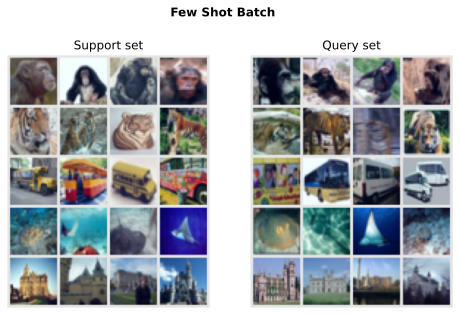

In [35]:
imgs, targets = next(iter(val_loader))  # We use the validation set since it does not apply augmentations
support_imgs, query_imgs, _, _ = split_batch(imgs, targets)
support_grid = torchvision.utils.make_grid(support_imgs, nrow=K_SHOT, normalize=True, pad_value=0.9)
support_grid = support_grid.permute(1, 2, 0)
query_grid = torchvision.utils.make_grid(query_imgs, nrow=K_SHOT, normalize=True, pad_value=0.9)
query_grid = query_grid.permute(1, 2, 0)

fig, ax = plt.subplots(1, 2, figsize=(8, 5))
ax[0].imshow(support_grid)
ax[0].set_title("Support set")
ax[0].axis('off')
ax[1].imshow(query_grid)
ax[1].set_title("Query set")
ax[1].axis('off')
plt.suptitle("Few Shot Batch", weight='bold')
plt.show() 
plt.close()

As we can see, the support and query set have the same five classes, but different examples. The models will be tasked to classify the examples in the query set by learning from the support set and its labels. With the data sampling in place, we can now start to implement our first meta-learning model: Prototypical Networks.

## Average Meter

It is a simple class for keeping training statistics, such as losses and accuracies etc. The .val field usually holds the statistics for the current batch, whereas the .avg field hold statistics for the current epoch.

In [32]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

## Prototypical Networks (ProtoNet)

The Prototypical Network (ProtoNet) is a metric-based meta-learning algorithm that operates similarly to the nearest neighbor classification. Metric-based meta-learning methods classify a new example $\mathbf{x}$ based on some distance function $d_{\varphi}$ between $x$ and all elements in the support set. ProtoNets implements this idea with the concept of prototypes in a learned feature space. First, ProtoNet uses an embedding function $f_{\theta}$ to encode each input in the support set into a $L$-dimensional feature vector. Next, for each class $c$, we collect the feature vectors of all examples with label $c$ and average their feature vectors. Formally, we can define this as:

$$\mathbf{v}_c=\frac{1}{|S_c|}\sum_{(\mathbf{x}_i,y_i)\in S_c}f_{\theta}(\mathbf{x}_i)$$

where $S_c$ is the part of the support set $S$ for which $y_i=c$, and $\mathbf{v}_c$ represents the _prototype_ of class $c$. The prototype calculation is visualized below for a 2-dimensional feature space and 3 classes (Figure credit - [Snell et al.](https://arxiv.org/pdf/1703.05175.pdf)). The colored dots represent encoded support elements with the color-corresponding class labels, and the black dots next to the class label are the averaged prototypes.

<center width="100%"><img src="https://github.com/AnjanDutta/SharedFigures/blob/main/protonet_classification.svg?raw=true" width="300px"></center>

Based on these prototypes, we want to classify a new example. Remember that since we want to learn the encoding function $f_{\theta}$, this classification must be differentiable, and hence, we need to define a probability distribution across classes. For this, we will make use of the distance function $d_{\varphi}$: the closer a new example $\mathbf{x}$ is to a prototype $\mathbf{v}_c$, the higher the probability for $\mathbf{x}$ belonging to class $c$. Formally, we can simply use a softmax over the distances of $\mathbf{x}$ to all class prototypes:

$$p(y=c\vert\mathbf{x})=\text{softmax}(-d_{\varphi}(f_{\theta}(\mathbf{x}), \mathbf{v}_c))=\frac{\exp\left(-d_{\varphi}(f_{\theta}(\mathbf{x}), \mathbf{v}_c)\right)}{\sum_{c'\in \mathcal{C}}\exp\left(-d_{\varphi}(f_{\theta}(\mathbf{x}), \mathbf{v}_{c'})\right)}$$

Note that the negative sign is necessary since we want to increase the probability for close-by vectors and have a low probability for distant vectors. We train the network $f_{\theta}$ based on the cross-entropy error of the training query set examples. Thereby, the gradient flows through both the prototypes $\mathbf{v}_c$ and the query set encodings $f_{\theta}(\mathbf{x})$. For the distance function $d_{\varphi}$, we can choose any function as long as it is differentiable concerning both of its inputs. The most common function, which we also use here, is the squared euclidean distance, but there have been several works on different distance functions as well.

### ProtoNet implementation

Now that we know how a ProtoNet works in principle, let's look at how we can apply it to our specific problem of few-shot image classification, and implement it below. First, we need to define the encoder function $f_{\theta}$. Since we work with CIFAR images, we can take a look back at Tutorial 5 where we compared common Computer Vision architectures, and choose one of the best-performing ones. Here, we go with a DenseNet since it is in general more parameter efficient than ResNet. Luckily, we do not need to implement DenseNet ourselves again and can rely on torchvision's model package instead. We use common hyperparameters of 64 initial feature channels, add 32 per block, and use a bottleneck size of 64 (i.e. 2 times the growth rate). We use 4 stages of 6 layers each, which results in overall about 1 million parameters. Note that the torchvision package assumes that the last layer is used for classification and hence calls its output size `num_classes`. However, we can instead just use it as the feature space of ProtoNet and choose an arbitrary dimensionality. We will use the same network for other algorithms in this notebook to ensure a fair comparison.

In [36]:
def get_convnet(output_size):
    convnet = torchvision.models.DenseNet(growth_rate=32,
                                          block_config=(6, 6, 6, 6),
                                          bn_size=2,
                                          num_init_features=64,
                                          num_classes=output_size)  # Output dimensionality
    return convnet

Next, we can look at implementing ProtoNet. The first step during training is to encode all images in a batch with our network. Next, we calculate the class prototypes from the support set (function `calculate_prototypes`), and classify the query set examples according to the prototypes (function `classify_feats`). Keep in mind that we use the data sampling described before, such that the support and query set are stacked together in the batch. Thus, we use our previously defined function `split_batch` to split them apart. The full code can be found below.

In [37]:
import torch.nn as nn
import torch.nn.functional as F

class ProtoNet(nn.Module):

    def __init__(self, proto_dim, device):
        """
        Inputs
            proto_dim - Dimensionality of prototype feature space
            device - Device: cuda or cpu
        """
        super().__init__()
        self.model = get_convnet(output_size=proto_dim)
        self.device = device

    @staticmethod
    def calculate_prototypes(features, targets):
        # Given a stack of features vectors and labels, return class prototypes
        # features - shape [N, proto_dim], targets - shape [N]
        classes, _ = torch.unique(targets).sort()  # Determine which classes we have
        prototypes = []
        for c in classes:
            p = features[torch.where(targets == c)[0]].mean(dim=0)  # Average class feature vectors
            prototypes.append(p)
        prototypes = torch.stack(prototypes, dim=0)
        # Return the 'classes' tensor to know which prototype belongs to which class
        return prototypes, classes

    def classify_feats(self, prototypes, classes, feats, targets):
        # Classify new examples with prototypes and return classification error
        dist = torch.pow(prototypes[None, :] - feats[:, None], 2).sum(dim=2)  # Squared euclidean distance
        preds = F.log_softmax(-dist, dim=1)
        labels = (classes[None, :] == targets[:, None]).long().argmax(dim=-1)
        acc = (preds.argmax(dim=1) == labels).float().mean()
        return preds, labels, acc

    def forward(self, batch):
        # Determine training loss for a given support and query set
        imgs, targets = batch
        imgs, targets = imgs.to(self.device), targets.to(self.device)
        features = self.model(imgs)  # Encode all images of support and query set
        support_feats, query_feats, support_targets, query_targets = split_batch(features, targets)
        prototypes, classes = self.calculate_prototypes(support_feats, support_targets)
        preds, labels, acc = self.classify_feats(prototypes, classes, query_feats, query_targets)
        loss = F.cross_entropy(preds, labels)
        return loss

    def training_step(self, batch, batch_idx):
        return self.calculate_loss(batch, mode="train")

    def validation_step(self, batch, batch_idx):
        _ = self.calculate_loss(batch, mode="val")

For validation, we use the same principle as training and sample support and query sets from the hold-out 10 classes. However, this gives us noisy scores depending on which query sets are chosen to which support sets. This is why we will use a different strategy during testing. For validation, our training strategy is sufficient since it is much faster than testing, and gives a good estimate of the training generalization as long as we keep the support-query sets constant across validation iterations.

## Train and Test Functions

### Training

The following training code is very similar to the previous tutorials.

In [38]:
from tqdm.notebook import tqdm
##define train function
def train(model, device, train_loader, optimizer):
    # meter
    loss = AverageMeter()
    # switch to train mode
    model.train()
    tk0 = tqdm(train_loader, total=int(len(train_loader)))
    for batch_idx, data in enumerate(tk0):
        # after fetching the data transfer the model to the
        # compute the forward pass
        # it can also be achieved by model.forward(data)
        loss_this = model(data)
        # initialize the optimizer
        optimizer.zero_grad()
        # compute the backward pass
        loss_this.backward()
        # update the parameters
        optimizer.step()
        # update the loss meter
        loss.update(loss_this.item(), data[1].shape[0])
    print('Train: Average loss: {:.4f}\n'.format(loss.avg))
    return loss.avg

### Testing

Our goal of meta-learning is to obtain a model that can quickly adapt to a new task, or in this case, new classes to distinguish between. To test this, we will use our trained ProtoNet and adapt it to the 10 test classes. Thereby, we pick $k$ examples per class from which we determine the prototypes and test the classification accuracy on all other examples. This can be seen as using the $k$ examples per class as a support set, and the rest of the dataset as a query set. We iterate through the dataset such that each example has been once included in a support set. The average performance across all support sets tells us how well we can expect ProtoNet to perform when seeing only $k$ examples per class. During training, we used $k=4$. In testing, we will experiment with $k=\{2,4,8,16,32\}$ to get a better sense of how $k$ influences the results. We would expect that we achieve higher accuracies the more examples we have in the support set, but we don't know how it scales. Hence, let's first implement a function that executes the testing procedure for a given $k$:

In [40]:
from statistics import mean, stdev

@torch.no_grad()
def test(model, dataset, data_feats=None, k_shot=4):
    """
    Inputs
        model - Pretrained ProtoNet model
        dataset - The dataset on which the test should be performed.
                  Should be instance of ImageDataset
        data_feats - The encoded features of all images in the dataset.
                     If None, they will be newly calculated, and returned
                     for later usage.
        k_shot - Number of examples per class in the support set.
    """
    model = model.to(device)
    model.eval()
    num_classes = dataset.targets.unique().shape[0]
    exmps_per_class = dataset.targets.shape[0]//num_classes  # We assume uniform example distribution here

    # The encoder network remains unchanged across k-shot settings. Hence, we only need
    # to extract the features for all images once.
    if data_feats is None:
        # Dataset preparation
        dataloader = data.DataLoader(dataset, batch_size=128, num_workers=2, shuffle=False, drop_last=False)

        img_features = []
        img_targets = []
        for imgs, targets in tqdm(dataloader, "Extracting image features", leave=False):
            imgs = imgs.to(device)
            feats = model.model(imgs)
            img_features.append(feats.detach().cpu())
            img_targets.append(targets)
        img_features = torch.cat(img_features, dim=0)
        img_targets = torch.cat(img_targets, dim=0)
        # Sort by classes, so that we obtain tensors of shape [num_classes, exmps_per_class, ...]
        # Makes it easier to process later
        img_targets, sort_idx = img_targets.sort()
        img_targets = img_targets.reshape(num_classes, exmps_per_class).transpose(0, 1)
        img_features = img_features[sort_idx].reshape(num_classes, exmps_per_class, -1).transpose(0, 1)
    else:
        img_features, img_targets = data_feats

    # We iterate through the full dataset in two manners. First, to select the k-shot batch.
    # Second, the evaluate the model on all other examples
    accuracies = []
    for k_idx in tqdm(range(0, img_features.shape[0], k_shot), "Evaluating prototype classification", leave=False):
        # Select support set and calculate prototypes
        k_img_feats, k_targets = img_features[k_idx:k_idx+k_shot].flatten(0,1), img_targets[k_idx:k_idx+k_shot].flatten(0,1)
        prototypes, proto_classes = model.calculate_prototypes(k_img_feats, k_targets)
        # Evaluate accuracy on the rest of the dataset
        batch_acc = 0
        for e_idx in range(0, img_features.shape[0], k_shot):
            if k_idx == e_idx:  # Do not evaluate on the support set examples
                continue
            e_img_feats, e_targets = img_features[e_idx:e_idx+k_shot].flatten(0,1), img_targets[e_idx:e_idx+k_shot].flatten(0,1)
            _, _, acc = model.classify_feats(prototypes, proto_classes, e_img_feats, e_targets)
            batch_acc += acc.item()
        batch_acc /= img_features.shape[0]//k_shot-1
        accuracies.append(batch_acc)

    return (mean(accuracies), stdev(accuracies)), (img_features, img_targets)

## Initialization

### Model

Below is the call for our ProtoNet. We use a 64-dimensional feature space. Larger feature spaces showed to give noisier results since the squared euclidean distance becomes proportionally larger in expectation, and smaller feature spaces might not allow for enough flexibility. We recommend to load the pre-trained model here at first, but feel free to play around with the hyperparameters yourself.

In [41]:
# device: cuda (gpu) or cpu
device = "cuda"
# define the model
model = ProtoNet(proto_dim=64, device=device) # proto_dim = 64, device = cuda
# map to device, `model.cuda()` will also do the same job
model = model.to(device)
# make the parameters trainable
for param in model.parameters():
    param.requires_grad = True

### Optimizer

In [42]:
import torch.optim as optim
## some hyperparameters related to optimizer
learning_rate = 0.0001
weight_decay = 0.0005
# define optimizer
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

## Training Loop
After implementing the model and other necessary components, we can start training it. It would be good to train the model for 200 epochs, but that will take 6 to 7 hours. So for brevity, we will train it only for 10 epochs which will take about 15 to 20 minutes.

In [43]:
num_epoch = 10
for epoch in range(1, num_epoch + 1):
    epoch_loss = train(model, device, train_loader, optimizer)

  0%|          | 0/1200 [00:00<?, ?it/s]

Train: Average loss: 1.4626



  0%|          | 0/1200 [00:00<?, ?it/s]

Train: Average loss: 1.2872



  0%|          | 0/1200 [00:00<?, ?it/s]

Train: Average loss: 1.2263



  0%|          | 0/1200 [00:00<?, ?it/s]

Train: Average loss: 1.1686



  0%|          | 0/1200 [00:00<?, ?it/s]

Train: Average loss: 1.1276



  0%|          | 0/1200 [00:00<?, ?it/s]

Train: Average loss: 1.0926



  0%|          | 0/1200 [00:00<?, ?it/s]

Train: Average loss: 1.0630



  0%|          | 0/1200 [00:00<?, ?it/s]

Train: Average loss: 1.0344



  0%|          | 0/1200 [00:00<?, ?it/s]

Train: Average loss: 1.0111



  0%|          | 0/1200 [00:00<?, ?it/s]

Train: Average loss: 0.9775



Testing ProtoNet is relatively quick if we have processed all images once. Hence, we can do in this notebook very efficiently.

In [47]:
protonet_accuracies = dict()
data_feats = None
for k in [2, 4, 8, 16, 32]:
    protonet_accuracies[k], data_feats = test(model, test_set, data_feats=data_feats, k_shot=k)
    print(f"Accuracy for k={k}: {100.0*protonet_accuracies[k][0]:4.2f}% (+-{100*protonet_accuracies[k][1]:4.2f}%)")

Extracting image features:   0%|          | 0/47 [00:00<?, ?it/s]

Evaluating prototype classification:   0%|          | 0/300 [00:00<?, ?it/s]

Accuracy for k=2: 31.76% (+-3.66%)


Evaluating prototype classification:   0%|          | 0/150 [00:00<?, ?it/s]

Accuracy for k=4: 38.51% (+-2.67%)


Evaluating prototype classification:   0%|          | 0/75 [00:00<?, ?it/s]

Accuracy for k=8: 43.64% (+-1.74%)


Evaluating prototype classification:   0%|          | 0/38 [00:00<?, ?it/s]

Accuracy for k=16: 48.19% (+-1.05%)


Evaluating prototype classification:   0%|          | 0/19 [00:00<?, ?it/s]

Accuracy for k=32: 51.53% (+-0.87%)


Before discussing the results above, let's first plot the accuracies over number of examples in the support set:

In [50]:
def plot_few_shot(acc_dict, name, color=None, ax=None):
    sns.set()
    if ax is None:
        fig, ax = plt.subplots(1,1,figsize=(5,3))
    ks = sorted(list(acc_dict.keys()))
    mean_accs = [acc_dict[k][0] for k in ks]
    std_accs = [acc_dict[k][1] for k in ks]
    ax.plot(ks, mean_accs, marker='o', markeredgecolor='k', markersize=6, label=name, color=color)
    ax.fill_between(ks, [m-s for m,s in zip(mean_accs, std_accs)], [m+s for m,s in zip(mean_accs, std_accs)], alpha=0.2, color=color)
    ax.set_xticks(ks)
    ax.set_xlim([ks[0]-1, ks[-1]+1])
    ax.set_xlabel("Number of shots per class", weight='bold')
    ax.set_ylabel("Accuracy", weight='bold')
    if len(ax.get_title()) == 0:
        ax.set_title("Few-Shot Performance " + name, weight='bold')
    else:
        ax.set_title(ax.get_title() + " and " + name, weight='bold')
    ax.legend()
    return ax

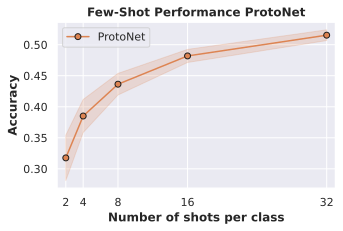

In [51]:
ax = plot_few_shot(protonet_accuracies, name="ProtoNet", color="C1")
plt.show()
plt.close()

As we initially expected, the performance of ProtoNet indeed increases the more samples we have. However, even with just two samples per class, we classify almost half of the images correctly, which is well above random accuracy (10%). The curve shows an exponentially dampend trend, meaning that adding 2 extra examples to $k=2$ has a much higher impact than adding 2 extra samples if we already have $k=16$. Nonetheless, we can say that ProtoNet adapts fairly well to new classes.

## Conclusion

In this notebook, we have discussed meta-learning algorithms that learn to adapt to new classes and/or tasks with just a few samples. We have implemented Prototypical Network (ProtoNet). On the few-shot image classification task of CIFAR100, ProtoNet showed to perform reasonably well. It will also be interesting to try and implement other models such as, __Model-Agnostic Meta-Learning / MAML__ ([Finn et al., 2017](http://proceedings.mlr.press/v70/finn17a.html)), and __Proto-MAML__ ([Triantafillou et al., 2020](https://openreview.net/pdf?id=rkgAGAVKPr)) for the same task.